In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get Data

Get the Daily Interest Rate swaps data from ICE based on 11:00am London Time. Swap data here has been taken and aggregated from: https://fred.stlouisfed.org/ 

In [2]:
#Read data from csv file
swaps_data = pd.read_csv("all_swaps_data.csv", index_col = 0)

In [3]:
swaps_data.tail()

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
DATE,,,,,,,,,,,,,
2020-12-25,0.196,0.208,0.250,0.339,0.446,0.559,0.668,0.768,0.859,0.939,1.202,1.327,1.414
2020-12-28,0.198,0.212,0.257,0.350,0.460,0.576,0.687,0.789,0.881,0.963,1.228,1.355,1.445
2020-12-29,0.200,0.210,0.253,0.342,0.449,0.565,0.675,0.775,0.867,0.947,1.215,1.343,1.432
2020-12-30,0.194,0.204,0.248,0.336,0.443,0.560,0.671,0.772,0.863,0.945,1.214,1.343,1.432
2020-12-31,0.193,0.200,0.243,0.329,0.432,0.548,0.658,0.758,0.848,0.928,1.196,1.324,1.413


** A brief primer on Interest Rate Swaps:** <br/>
- An interest rate swap is an agreement where one party (Party A) pays a fixed rate ($x$) while the other party (Party B) pays a floating rate ($f$) that is determined by the London Interbank Offer Rate (LIBOR).<br/>
- The most conventional type of Interest Rate Swap is a Semi-Bond interest rate swap where Party A (the payer of the fixed rate) will pay Party B a fixed rate of $x$ every 6 months while Party B (the payer of the floating rate) will pay Party A a floating rate of $f$ every 3 months. <br/>
- Note that $f$ is only known 2 days before Party B pays Party A while $x$ is known when the agreement is being made. <br/>

** So what is the Swap Rate that we see in the dataframe above? ** <br/>
- The dataframe above shows the fixed rate $x$ that Party A is to pay Party B every 6 months while receiving the floating rate $f$ from Party B every 3 months <br/>
- Mathematically, $x$ is set such that the Interest Rate Swap is a "fair deal" (in laymen terms) or where the Interest Rate Swap has a Present Value of 0.


## Swap Curve

We can visualize how the swap curve look like for a given day. Using 31st Dec 2020, where the x-axis is the tenor of the swap while the y-axis is the swap rate:

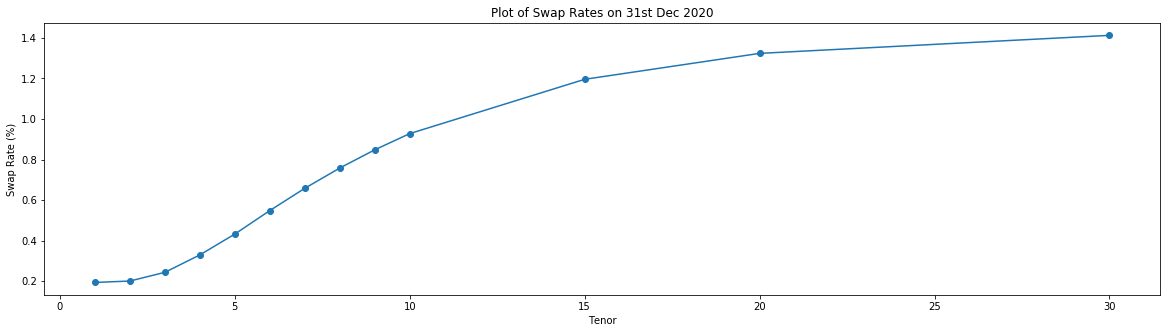

In [4]:
#Plot of swap curve for 31st Dec 2020
data_point = swaps_data.loc['2020-12-31', :]
tenors = [int(s[:-1]) for s in data_point.index]
plt.figure(figsize=(20, 5))
plt.plot(tenors, data_point, marker = "o")
plt.title("Plot of Swap Rates on 31st Dec 2020")
plt.xlabel("Tenor")
plt.ylabel("Swap Rate (%)");

## Problem for Traders and Portfolio Managers

In a particularly fast-paced environment, it will be hard for traders and portfolio managers to manage their risk with a huge number of Interest Rate Swaps due to the many swap tenors that might be in their portfolio. Thus, some sort of dimension reduction technique must be used to reduce their portfolio risk to something that is more simplistic and easier to manage. We look for a simple, tractable and intuitive method for dimension reduction: Principal Component Analysis <br/>

## Principal Component Analysis
Principal Component Analysis (PCA) is one of the many methods used in finance to create factor models. PCA in the rates space is analagous to Factor Analysis in the equity space where risk with a large dimension is broken down to fewer dimensions that are easier to monitor. <br>
- We determine the number of dimensions $d$ to reduce our data set to. <br>
- The goal of PCA here is to get $d$ projection vectors such that the variance explained by these vectors are maximized. <br>
- Mathematically, the top $d$ projection vectors are the eigenvectors that correspond to the top $d$ eigenvalues of the covariance matrix. <br>

In [32]:
def get_eigenvectors(cov_df):
    "Function to get eigenvalues and eigenvectors of the covariance matrix"
    vals, vecs = np.linalg.eigh(cov_df)
    #sort the indices based on the eigenvalues
    idx = np.argsort(vals)[::-1]
    vecs = vecs[:,idx]
    vals = vals[idx]
    return vals, vecs

#### Step 1: Get the swap changes
We arbitrarily use 100 data points in for the training data set and the rest of the data for the test data set. Rate changes instead of swap rate levels are used as swap rates usually exhibit auto-correlation which will affect the descriptive ability of PCA. 

In [33]:
#Get differences and drop all NAs
changes = swaps_data.diff().dropna() 
changes_train = changes.iloc[:100]
changes_test = changes.iloc[100:]

#### Step 2: Carry out PCA 
- We specify the number of dimensions to reduce to: 3<br> 
- With the data we have, we get the covariance matrix <br>
- Get the eigenvectors correspond to the top 3 eigenvalues <br>

In [50]:
#Carry out PCA on training dataset
num_components = 3 #Number of dimensions
evals, evecs = get_eigenvectors(changes_train.cov())
pcs = evecs[:, :num_components]

## Principal Component Plots
There are two plots below:

### 1) Plot of PC Coefficients

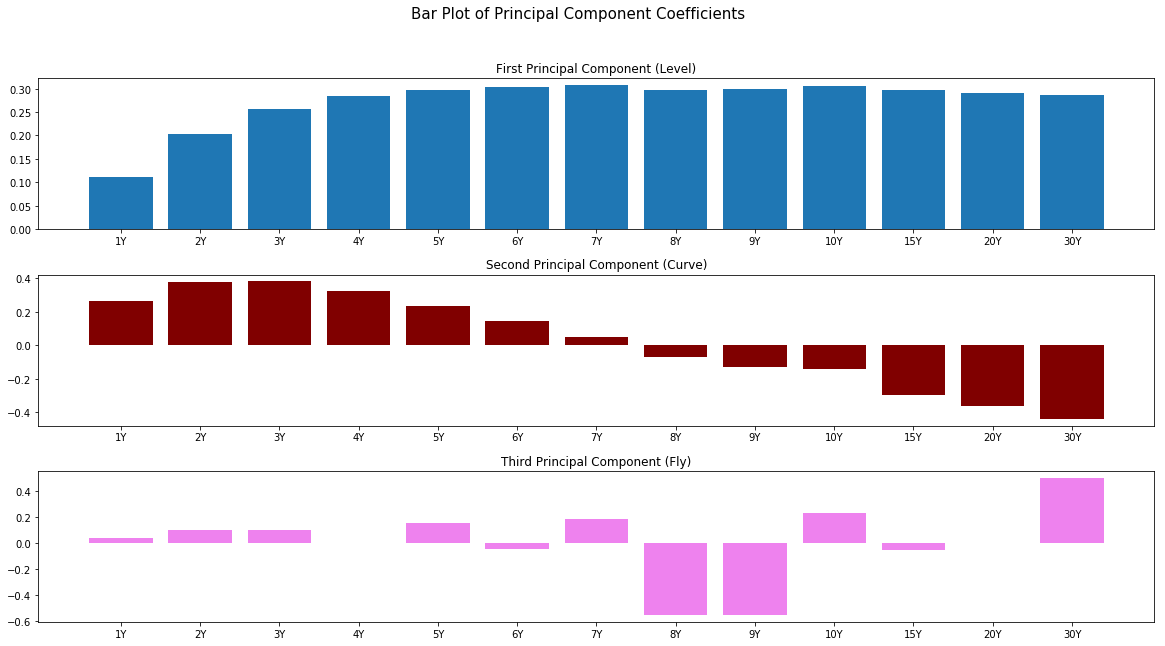

In [35]:
#PC Coefs Plot
fig, ax = plt.subplots(3,1, figsize = (20,10))

plt.subplots_adjust(hspace = 0.3)
ax[0].bar(changes.columns, pcs[:,0])
ax[0].set_title("First Principal Component (Level)")
ax[1].bar(changes.columns, pcs[:,1], color = "maroon")
ax[1].set_title("Second Principal Component (Curve)")
ax[2].bar(changes.columns, pcs[:,2], color = "violet")
ax[2].set_title("Third Principal Component (Fly)")
fig.suptitle("Bar Plot of Principal Component Coefficients", fontsize=15);

**First Component**: <br/>
- Usually termed `level`. We can see that all the coefficents in PC1 have the same sign.<br/>
- This means that all the swap rates usually move in the same direction <br/>

**Second Component**: <br/>
- Usually termed `curve`. We can see that the coefficients across the tenors are in a descending order. <br/>
- This means that after the first component is accounted for, the shorter tenors move in the opposite direction as the longer tenors

**Third Component**: <br/>
- Usually termed `fly` or `twist`. We can see that the coefficients of the shorter and the longer tenors have the same signs while the middle tenors usually have opposite signs. <br/>
- This means that after the first and second components are accounted for, the shorter tenors move in the same direction while the middle tenors move in the opposite direction.

### 2) Plot of Total Variance explained

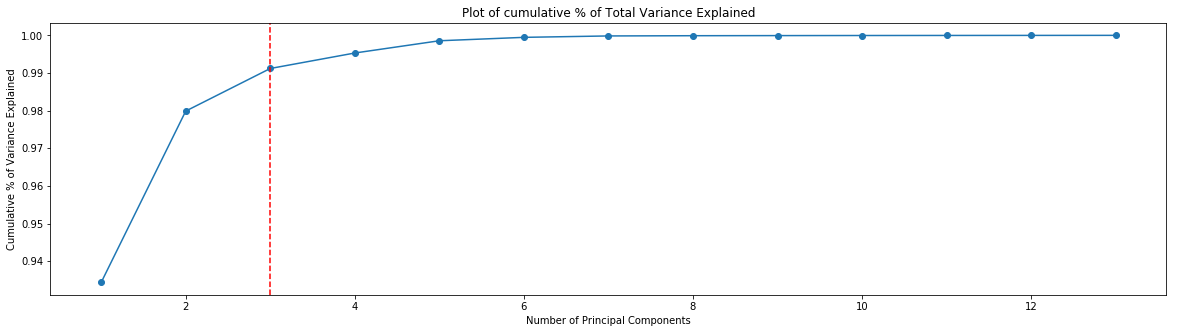

In [38]:
#Variance Plot
plt.figure(figsize = (20,5))
plt.plot(np.arange(1, len(evals) + 1), (evals/evals.sum()).cumsum(), marker = "o")
plt.title("Plot of cumulative % of Total Variance Explained")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative % of Variance Explained")
plt.axvline(x = 3, color = "red", ls='--');

The interpretations of the respective principal components were explained in the previous figure. This figure shows the cumulative variance explained as we add more factors/ increase the dimensionality of the transformed data. 3 components are usually used as they account for almost 99% of the total variance and will still remain interpretable.

## How Principal Components can be used:

### i) Risk Management
Manage risk to factors instead of risk to multiple tenors

Assume that a Trader has a portfolio of swaps with risk such as:

In [39]:
#Hypothetical Risk Portfolio
portfolio_risk = pd.DataFrame(index = changes.columns)
portfolio_risk["Risk"] = [0, 5000, -95000, 30000, -20000, 3000, 56000, 78000, -45000, 30000, 50000, -1200, 40000]
portfolio_risk.T

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
Risk,0,5000,-95000,30000,-20000,3000,56000,78000,-45000,30000,50000,-1200,40000


*The risk table can be interpreted as the change to the portfolio value if the relevant swap rate moves by 1 bp ($0.01$%). For example, based on the risk table, the portfolio's risk to the `30Y` swap rate is \$ $40,000$. If the `30Y` swap rate moves by $0.01$% ($1.30$% to $1.31$%), the portfolio will gain \$ $40,000$.

In [40]:
#PC Risk Dataframe
pc1 = pcs[:, 0]
pc2 = pcs[:, 1]
pc3 = pcs[:, 2]

#Collapse the risk to factor risk
pc1_risk = np.dot(portfolio_risk.T, pc1)[0]
pc2_risk = np.dot(portfolio_risk.T, pc2)[0]
pc3_risk = np.dot(portfolio_risk.T, pc3)[0]

pc_df = pd.DataFrame(index = ["PC1", "PC2", "PC3"])
pc_df["Risk"] = [pc1_risk, pc2_risk, pc3_risk]
pc_df = pc_df.round()
pc_df.T

,PC1,PC2,PC3
Risk,42254.0,-62075.0,3895.0


Instead of seeing viewing the portfolio risks to a number of swap rates, the Trader can see his/her risk in a more simplistic way in terms of risk to PC factors. It will be easier for the Trader to manage risk to just a few factors instead of multiple swap instruments.

### ii) Hedging

In expressing the portfolio risk in terms of risk to PC factors, PCA is also used for managing the hedging of the PC factors. Some tenors like 5Y, 10Y, 30Y swaps might be more liquid than 4Y, 7Y, 8Y swaps. Thus traders might prefer to hedge their portfolio risk with certain tenors. <br/> 
#### So, how would PCA help with this?

##### a) Hedging All Risk
Hedge all factor risk in the portfolio (Expand for Example)

Following the previous example in `(i)`, our PC1 risk 42254.0 , our PC2 risk is -62075.0  and our PC3 risk is 3895.0 . To completely hedge the PC1 risk, PC2 risk and PC3 risk, we need at least 3 instruments to hedge it. <br/>
We need to figure our how much 5Y ($R_{5Y}$), 5Y ($R_{10Y}$) and 30Y ($R_{30Y}$) risk the portfolio should take on to be PC risk neutral. We can express it in 3 simultaneous equations to find $R_{5Y}$, $R_{10Y}$, $R_{30Y}$:

$PC1_{5Y} \cdot R_{5Y} + PC1_{10Y} \cdot R_{10Y} + PC1_{30Y} \cdot R_{30Y} =  ${{round(pc1_risk)}}$ \rightarrow$ 1: To make portfolio PC1 neutral <br/>
$PC2_{5Y} \cdot R_{5Y} + PC2_{10Y} \cdot R_{10Y} + PC2_{30Y} \cdot R_{30Y} = ${{round(pc2_risk)}}$ \rightarrow$ 1: To make portfolio PC2 neutral <br/>
$PC3_{5Y} \cdot R_{5Y} + PC3_{10Y} \cdot R_{10Y} + PC3_{30Y} \cdot R_{30Y} = ${{round(pc3_risk)}}$ \rightarrow$ 1: To make portfolio PC3 neutral <br/>

In [41]:
pcs_df = pd.DataFrame(pcs).T
pcs_df.columns = changes.columns
pcs_df = pcs_df[["5Y", "10Y", "30Y"]]
pcs_df

,5Y,10Y,30Y
0,0.297436,0.305257,0.286257
1,0.234612,-0.143970,-0.438754
2,0.148211,0.230309,0.500553


Given the principle components for 5Y, 10Y and 30Y swaps, we can solve for $R_{5Y}$ and $R_{10Y}$, $R_{30Y}$:

$\   0.29\cdot R_{5Y} + 0.31 \cdot R_{10Y} + 0.28 \cdot R_{30Y} = ${{round(pc1_risk)}}$  \rightarrow$ : To make portfolio PC1 neutral <br/>
$     0.20 \cdot R_{5Y} - 0.16\cdot R_{10Y} - 0.48 \cdot R_{30Y} = ${{round(pc2_risk)}}$  \rightarrow$ : To make portfolio PC2 neutral <br/>
$-0.27 \cdot R_{5Y} - 0.20 \cdot R_{10Y} - 0.13 \cdot R_{30Y} = ${{round(pc3_risk)}}$  \rightarrow$ : To make portfolio PC3 neutral <br/>

In [51]:
#Portfolio PC Risk
target_risk = np.dot(np.linalg.inv(pcs_df),  pc_df)
target_risk_df = pd.DataFrame(index = ["5Y", "10Y", "30Y"])
target_risk_df["Risk"] = target_risk
target_risk_df.T.round()

,5Y,10Y,30Y
Risk,-245316.0,531263.0,-164021.0


We can see that -245k of 5Y risk, 531k of 10Y risk and -164k of 30Y risk is needed to make the portfolio PC neutral. The risk of each swap tenor is greater than the risk in the existing tenors, but there are a few cavets to note: <br\>
1) There was a fair amount of PC1 and PC2 risk that the portfolio had <br\>
2) In practice, traders do not make their portfolio have 0 PC risk. <br\>

Nonetheless, a trader might be able to use PCA to make risk management far simpler as the trader does not have to think about each tenor inidivually.Thus, the PCA method does give a framework to simplify risk for traders.

#### b) Hedging one factor risk out
Just Hedge PC1 risk

Suppose that the trader just wants to hedge his/her PC1 risk out, but does not mind taking more PC2 and PC3 risk. Suppose too that the 10Y swap is the instrument chosen for hedging. 

In [43]:
#Calculate 10Y Risk Needed to be PC1 Neutral
amount_10y_risk = pc1_risk/pcs_df["10Y"].iloc[0]
round(amount_10y_risk)

138419.0

The new PC risk given by \${{int(amount_10y_risk)}} of 10Y will be:

In [44]:
#Calculate new PC risk
new_pc_risk = pd.DataFrame(amount_10y_risk * pcs_df["10Y"]).T
new_pc_risk = new_pc_risk.rename(columns = {0: "PC1", 1: "PC2", 2:"PC3"}).round()
new_pc_risk

,PC1,PC2,PC3
10Y,42254.0,-19928.0,31879.0


### iii) PnL Explanation
Another huge use of PCA is profit and loss attribution. A portfolio of swaps might make money, but trying to figure out where this profit came from might be a bit tricky. Lets use 10 days of changes data as an example: <br>

In [45]:
_10d_change = changes_test[:10]
_10d_total_change = _10d_change.sum()
_10d_change

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,30Y
DATE,,,,,,,,,,,,,
2016-05-24,0.008,0.017,0.018,0.019,0.018,0.018,0.016,0.016,0.016,0.016,0.015,0.016,0.017
2016-05-25,-0.004,-0.005,-0.003,-0.001,-0.001,-0.004,-0.007,-0.011,-0.013,-0.014,-0.016,-0.016,-0.016
2016-05-26,-0.025,-0.033,-0.033,-0.032,-0.028,-0.023,-0.020,-0.017,-0.015,-0.013,-0.009,-0.007,-0.006
2016-05-27,0.003,0.000,-0.004,-0.008,-0.009,-0.010,-0.009,-0.007,-0.006,-0.006,0.000,0.003,0.007
2016-05-30,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2016-05-31,0.022,0.032,0.035,0.035,0.032,0.029,0.026,0.023,0.020,0.018,0.011,0.008,0.005
2016-06-01,-0.002,-0.009,-0.015,-0.015,-0.017,-0.018,-0.021,-0.023,-0.024,-0.025,-0.030,-0.034,-0.037
2016-06-02,-0.007,-0.013,-0.016,-0.020,-0.022,-0.023,-0.021,-0.020,-0.019,-0.018,-0.022,-0.022,-0.023
2016-06-03,-0.062,-0.096,-0.110,-0.113,-0.108,-0.103,-0.099,-0.094,-0.089,-0.084,-0.066,-0.058,-0.048


After 10 days, the pnl to the porfolio can be calculated:

In [46]:
#Pnl of Portfolio
actual_pnl = round(np.dot(_10d_total_change, portfolio_risk)[0],2)
actual_pnl

-12999.0

However, the trader might want to know what caused his/her portfolio to lose/gain this amount of money. Sure, he/she can just look at the total 5d change and say that the portfolio gained from a raise in 2Y rates, loss from a drop in 3Y rates ... loss from a drop in 30Y rates. But this just seems unnecessarily verbose and uninformative.

Instead, the trader's portfolio can be explained by factor exposures to Principal Components:

In [47]:
#Calculate PC Attribution
pc1_change = np.dot(pc1, _10d_total_change)
pc2_change = np.dot(pc2, _10d_total_change)
pc3_change = np.dot(pc3, _10d_total_change)

pc1_explain = pc_df.loc["PC1"].values[0]*pc1_change
pc2_explain = pc_df.loc["PC2"].values[0]*pc2_change
pc3_explain = pc_df.loc["PC3"].values[0]*pc3_change
total_explain = pc1_explain + pc2_explain + pc3_explain

pc_explain_df = pd.DataFrame(index = ["PC1", "PC2", "PC3", "Total"])
pc_explain_df["Pnl"] = [pc1_explain, pc2_explain, pc3_explain, total_explain]
pc_explain_df.T.round()

,PC1,PC2,PC3,Total
Pnl,-15429.0,2360.0,6.0,-13063.0


The total pnl that is ***explained*** is  $ \$ ${{ round(total_explain) }} while the total ***actual*** pnl is $ \$ ${{ round(actual_pnl) }} which is pretty close. From this table, we can see that the trader loss $ \$ ${{ round(pc1_explain) }} from exposure to PC1, $ \$ ${{ round(pc2_explain) }}  from exposure to PC2 and $ \$ ${{ round(pc3_explain) }}  from PC3.

## Limitations/ Effectiveness

### i) Checking residuals
It is important to ensure that the our PCA model is effective. We can examine the residuals of the model by training the model on a training data set and then evaluating the model's effectiveness on a test set of data

In [48]:
#Process and calculate residuals
def projection(pcs, data_point):
    """Get projection of rate moves"""
    return np.dot(pcs, np.dot(pcs.T, data_point))
def get_resids(pcs, data_point):
    """Get residuals of rate moves"""
    return data_point - projection(pcs, data_point)

all_resids = changes_test.apply(lambda x: get_resids(pcs, x), axis = 1)
all_resids.index = pd.to_datetime(all_resids.index)
cum_resids = all_resids.cumsum()

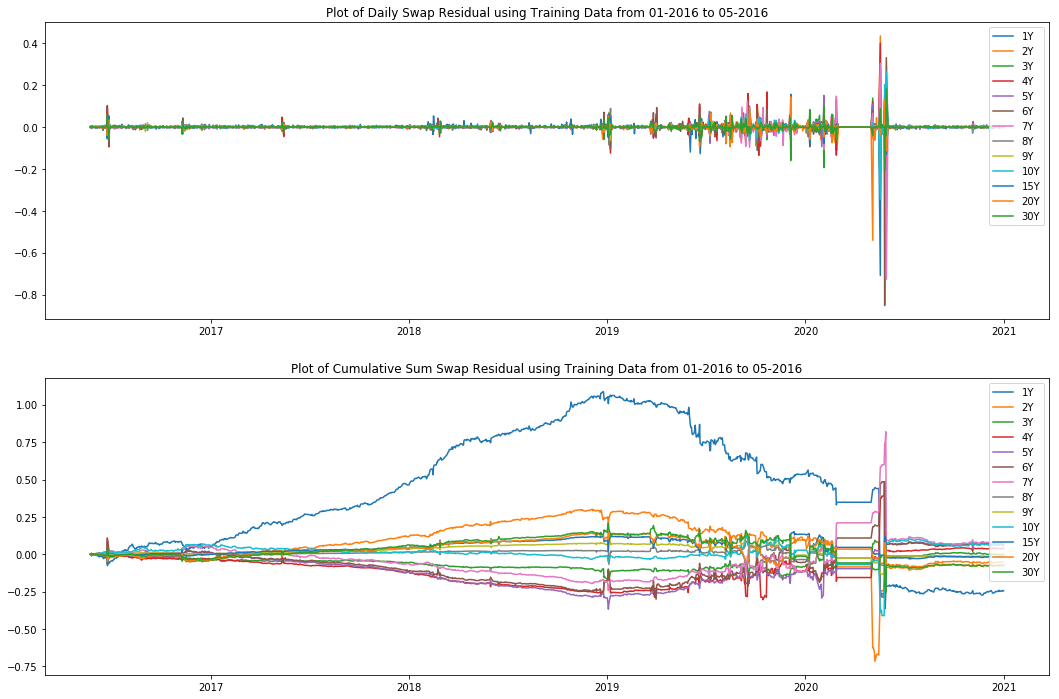

In [55]:
#Plot of Residuals


fig, ax = plt.subplots(2,1, figsize = (18,12))
ax[0].plot(all_resids);
ax[0].legend(all_resids.columns, loc = "upper right")
ax[0].set_title("Plot of Daily Swap Residual using Training Data from 01-2016 to 05-2016");

ax[1].plot(cum_resids);
ax[1].legend(cum_resids.columns)
ax[1].set_title("Plot of Cumulative Sum Swap Residual using Training Data from 01-2016 to 05-2016");

### Observations:
##### Daily Swap Residual Plot
1. We can see that the daily swap residual for each tenor is approximately normal distributed <br>
2. We see some daily residual spikes in 2020. This might be due to crazy market movements during the pandemic <br>

##### Cumulative Swap Residual Plot
1. We can see that the cumulative sum of residuals of the 1Y swap seems much higher than the cumulative sum of other tenors. This may suggest that the PCA model fits poorly on the 1Y swap <br>
2. We can see that the fit gets worst as time goes by. This could be due to a regime change in the markets as the market between 01-2016 to 05-2016 is different from the market in 2020. ***The input data length as well as the frequency of re-training is more of a data science problem.***